In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import hcipy
from hcipy import *

In [2]:
# Parameters for the pupil function
pupil_diameter = 0.019725 # m
gap_size = 90e-6 # m
num_rings = 3
# computes width per segment
segment_flat_to_flat = (pupil_diameter - (2 * num_rings + 1) * gap_size) / (2 * num_rings + 1)
focal_length = 1 # m

# Parameters for the simulation
num_pix = 1024
wavelength = 638e-9
num_airy = 20
sampling = 4
norm = False

In [3]:
# HCIPy grids and propagator
pupil_grid = hcipy.make_pupil_grid(dims=num_pix, diameter=pupil_diameter)

focal_grid = hcipy.make_focal_grid(sampling, num_airy,
                                   pupil_diameter=pupil_diameter,
                                   reference_wavelength=wavelength,
                                   focal_length=focal_length)
focal_grid = focal_grid.shifted(focal_grid.delta / 2)

prop = hcipy.FraunhoferPropagator(pupil_grid, focal_grid, focal_length)

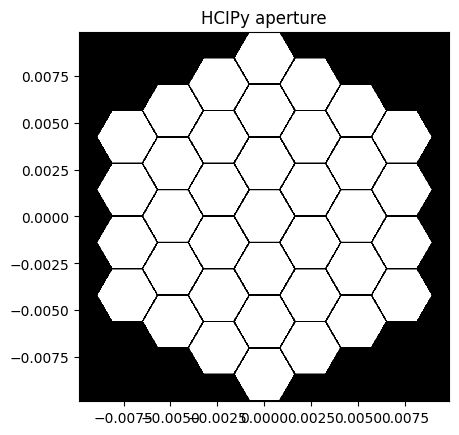

In [4]:
aper, segments = hcipy.make_hexagonal_segmented_aperture(num_rings,
                                                         segment_flat_to_flat,
                                                         gap_size,
                                                         starting_ring=0,
                                                         return_segments=True)

aper = hcipy.evaluate_supersampled(aper, pupil_grid, 4)
segments = hcipy.evaluate_supersampled(segments, pupil_grid, 4)

plt.title('HCIPy aperture')
hcipy.imshow_field(aper, cmap='gray')

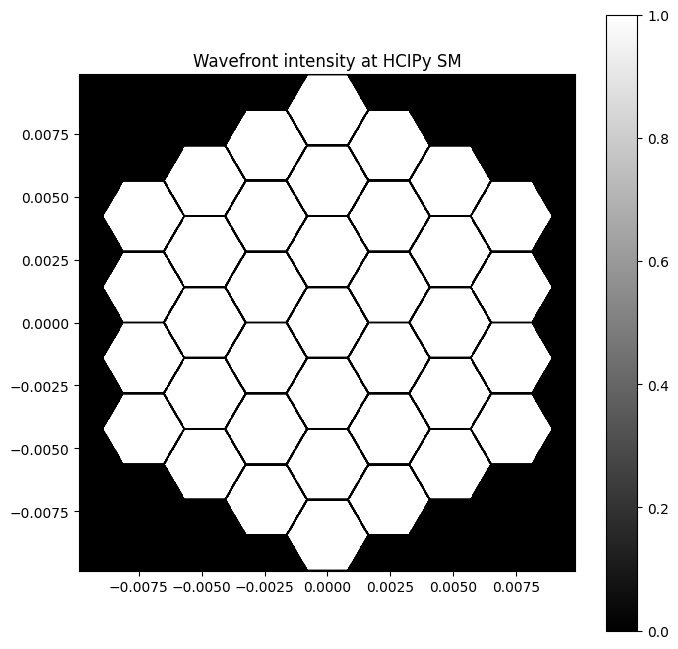

In [5]:
# Instantiate the segmented mirror
hsm = hcipy.SegmentedDeformableMirror(segments)

# Make a pupil plane wavefront from aperture
wf = hcipy.Wavefront(aper, wavelength)

# Apply SM if you want to
wf = hsm(wf)

plt.figure(figsize=(8, 8))
plt.title('Wavefront intensity at HCIPy SM')
hcipy.imshow_field(wf.intensity, cmap='gray')
plt.colorbar()
plt.show()

In [6]:
# Apply SM to pupil plane wf
wf_sm = hsm(wf)

# Propagate from SM to image plane
im_ref_hc = prop(wf_sm)

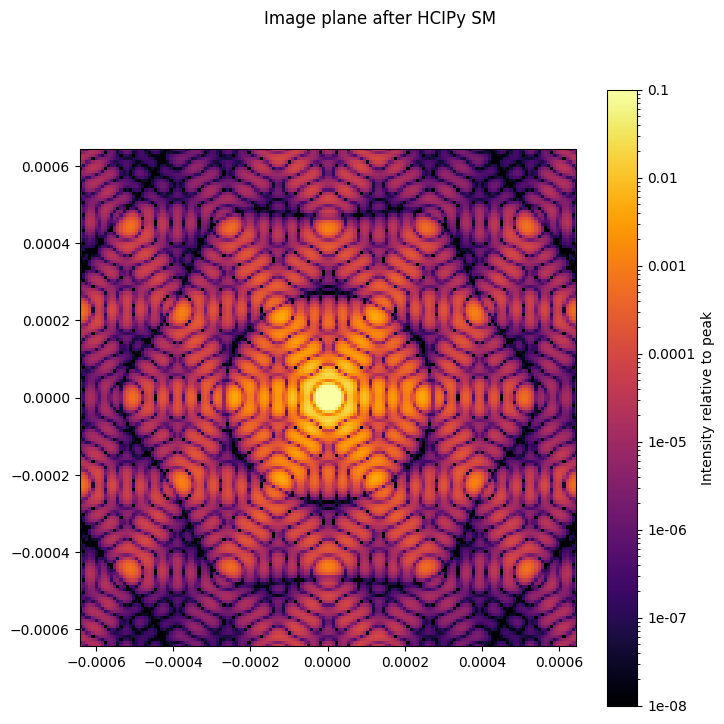

In [7]:
# Display intensity and phase in image plane
plt.figure(figsize=(8, 8))
plt.suptitle('Image plane after HCIPy SM')

# Get normalization factor for HCIPy reference image
norm_hc = np.max(im_ref_hc.intensity)

hcipy.imshow_psf(im_ref_hc, normalization='peak')

In [8]:
# Define function from rad of phase to m OPD
def aber_to_opd(aber_rad, wavelength):
    aber_m = aber_rad * wavelength / (2 * np.pi)
    return aber_m

aber_rad = 4.0

print('Aberration: {} rad'.format(aber_rad))
print('Aberration: {} m'.format(aber_to_opd(aber_rad, wavelength)))

Aberration: 4.0 rad
Aberration: 4.061634147705169e-07 m


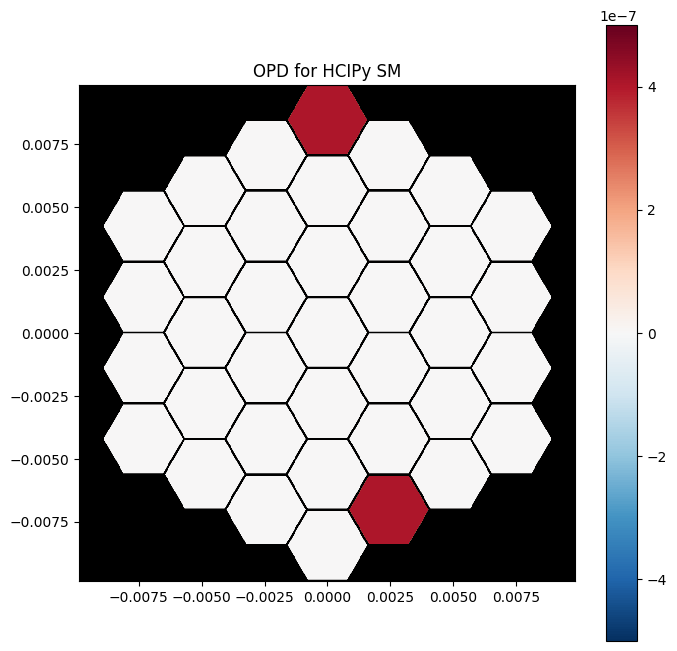

In [9]:
# Flatten both SMs just to be sure
hsm.flatten()

# Poking segment 35 and 25
for i in [35, 25]:
    hsm.set_segment_actuators(i, aber_to_opd(aber_rad, wavelength) / 2, 0, 0)

# Display both segmented mirrors in OPD

# HCIPy
plt.figure(figsize=(8,8))
plt.title('OPD for HCIPy SM')
hcipy.imshow_field(hsm.surface * 2, mask=aper, cmap='RdBu_r', vmin=-5e-7, vmax=5e-7)
plt.colorbar()
plt.show()

<>:11: SyntaxWarning: invalid escape sequence '\p'
<>:11: SyntaxWarning: invalid escape sequence '\p'
C:\Users\alexe\AppData\Local\Temp\ipykernel_3556\1772454174.py:11: SyntaxWarning: invalid escape sequence '\p'
  plt.suptitle('Image plane after SM for $\phi$ = ' + str(aber_rad) + ' rad')


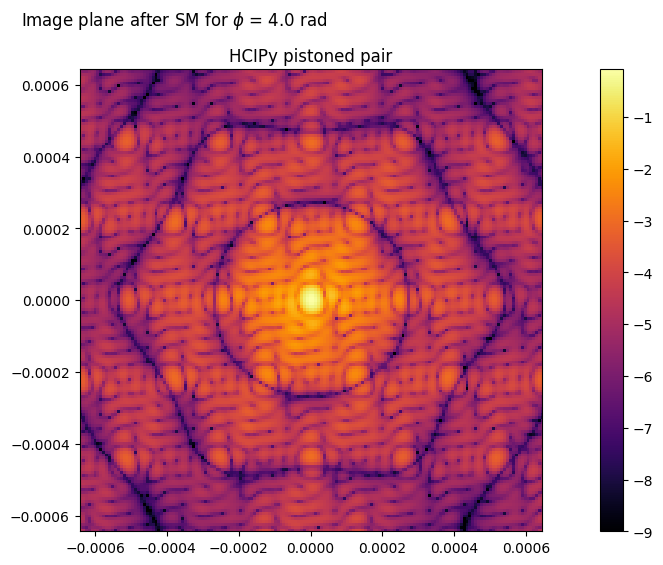

In [10]:
### HCIPy
# Apply SM to pupil plane wf
wf_fp_pistoned = hsm(wf)

# Propagate from SM to image plane
im_pistoned_hc = prop(wf_fp_pistoned)


### Display intensity of both cases image plane
plt.figure(figsize=(15, 6))
plt.suptitle('Image plane after SM for $\phi$ = ' + str(aber_rad) + ' rad')

hcipy.imshow_field(np.log10(im_pistoned_hc.intensity / norm_hc), cmap='inferno', vmin=-9)
plt.title('HCIPy pistoned pair')
plt.colorbar()

In [11]:
aber_rad_tt = 200e-6
aber_rad_p = 1.8

opd_piston = aber_to_opd(aber_rad_p, wavelength)

# Flatten both SMs
hsm.flatten()

## PISTON
for i in [19, 28, 23, 16]:
    hsm.set_segment_actuators(i, opd_piston / 2, 0, 0)

for i in [3, 35, 30, 8]:
    hsm.set_segment_actuators(i, -0.5 * opd_piston / 2, 0, 0)

for i in [14, 18, 1, 32, 12]:
    hsm.set_segment_actuators(i, 0.3 * opd_piston / 2, 0, 0)

## TIP and TILT
for i in [2, 5, 11, 15, 22]:
    hsm.set_segment_actuators(i, 0, aber_rad_tt / 2, 0.3 * aber_rad_tt / 2)

for i in [4, 6, 26]:
    hsm.set_segment_actuators(i, 0, -aber_rad_tt / 2, 0)

for i in [34, 31, 7]:
    hsm.set_segment_actuators(i, 0, 0, 1.3 * aber_rad_tt / 2)


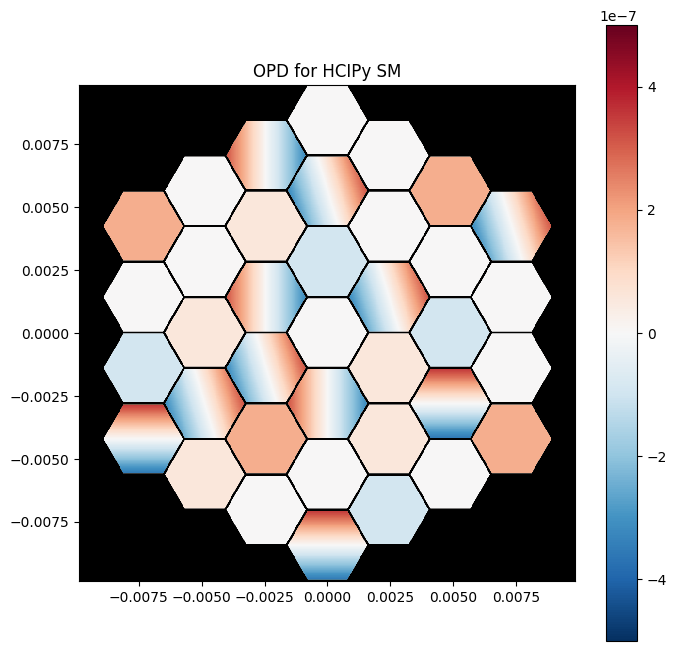

In [12]:
# Display both segmented mirrors in OPD

# HCIPy
plt.figure(figsize=(8,8))
plt.title('OPD for HCIPy SM')
hcipy.imshow_field(hsm.surface * 2, mask=aper, cmap='RdBu_r', vmin=-5e-7, vmax=5e-7)
plt.colorbar()
plt.show()


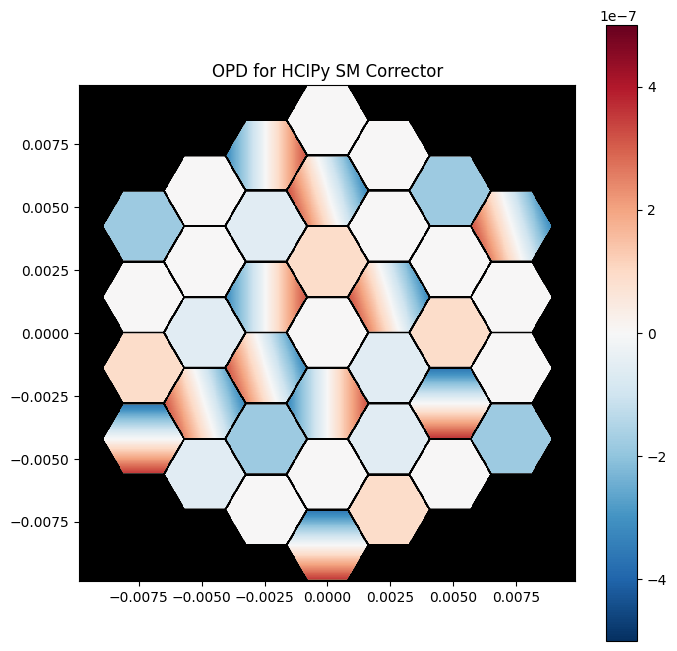

In [13]:
hsm_corrector = hcipy.SegmentedDeformableMirror(segments)

hsm_corrector.flatten()

for i in range(len(segments)):
    piston, tip, tilt = hsm.get_segment_actuators(i)
    hsm_corrector.set_segment_actuators(i, -piston, -tip, -tilt)

plt.figure(figsize=(8,8))
plt.title('OPD for HCIPy SM Corrector')
hcipy.imshow_field(hsm_corrector.surface * 2, mask=aper, cmap='RdBu_r', vmin=-5e-7, vmax=5e-7)
plt.colorbar()
plt.show()

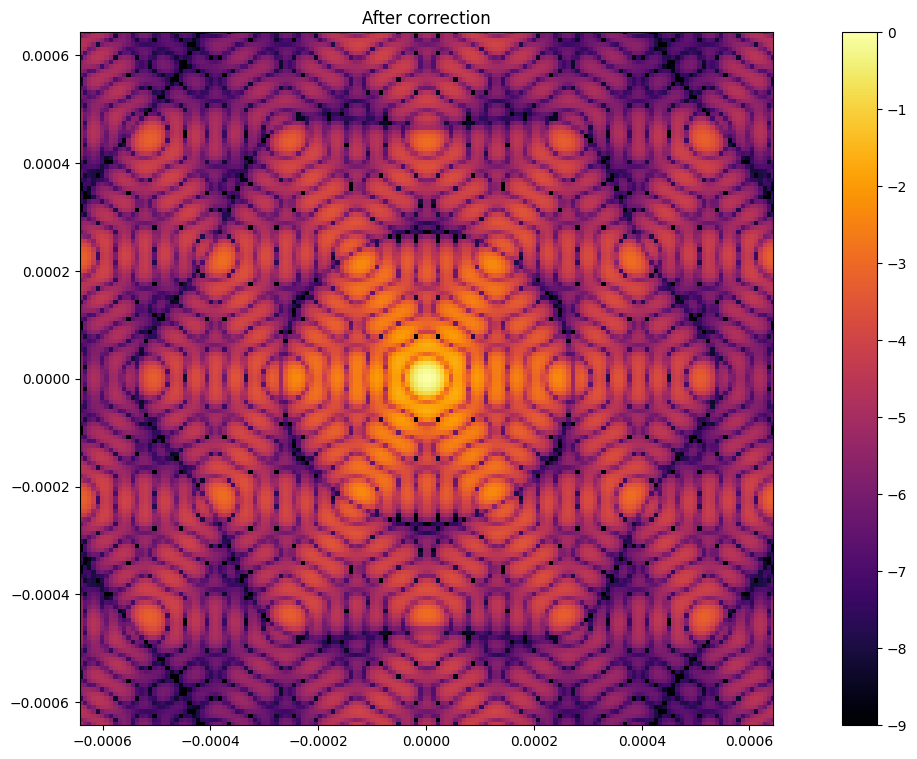

In [14]:
# Propagate from pupil plane through SM to image plane
im_pistoned_hc = prop(hsm_corrector(hsm(wf))).intensity

### Display intensity of both cases image plane
plt.figure(figsize=(18, 9))

hcipy.imshow_field(np.log10(im_pistoned_hc / norm_hc), cmap='inferno', vmin=-9)
plt.title('After correction')
plt.colorbar()


In [15]:
lyot_mask = hcipy.evaluate_supersampled(hcipy.make_circular_aperture(0.90), pupil_grid, 4)
lyot_stop = Apodizer(lyot_mask)
charge = 2
coro = hcipy.VortexCoronagraph(pupil_grid, charge)

# new_wf = hcipy.Wavefront(aper, wavelength)

fresh_hsm = hcipy.SegmentedDeformableMirror(segments)

Strehl ratio: 1.0


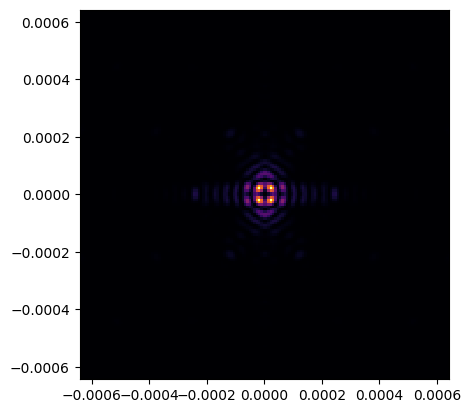

In [16]:
def get_image(corrector=True):

    c = hsm_corrector if corrector else fresh_hsm
    
    lyot_plane = prop(
                    lyot_stop(
                        coro(
                            c(
                                hsm(
                                    hcipy.Wavefront(aper, wavelength)
                                    )
                                )
                            )
                        )
                    ) 

    wf_aberrated = c(hsm(hcipy.Wavefront(aper, wavelength)))
    psf_aberrated = prop(wf_aberrated).intensity
    peak_aberrated = np.max(psf_aberrated)

    wf_ideal = hcipy.Wavefront(aper, wavelength)
    psf_ideal = prop(wf_ideal).intensity
    peak_ideal = np.max(psf_ideal)

    strehl = peak_aberrated / peak_ideal

    img_ref = prop(wf).intensity
    return lyot_plane.intensity / img_ref.max(), strehl

frame, strehl = get_image(corrector=True)

print(f"Strehl ratio: {strehl}")
imshow_field(frame, cmap='inferno')
plt.show()

In [17]:
import pygame

# Initialize pygame
pygame.init()

# Set up display
width, height = 800, 800
screen = pygame.display.set_mode((width, height))
pygame.display.set_caption('HCIPy Image Plane (Interactive)')

selected_segment = 0
piston_step = 3e-8  # Adjust as needed
manual_hsm = hcipy.SegmentedDeformableMirror(segments)

def update_surface():
    wf_updated = coro(manual_hsm(wf))
    im_pistoned_hc = prop(wf_updated).intensity
    norm = prop(manual_hsm(wf)).intensity.max()
    im_display = im_pistoned_hc / norm # np.log10(im_pistoned_hc / norm)
    print(im_display)
    im_display = im_display # np.clip(im_display, -9, 0)
    im_display = ((im_display + 9) / 9 * 255).astype(np.uint8)
    im_display = im_display.reshape(int(np.sqrt(im_display.size)), -1)
    return pygame.surfarray.make_surface(np.stack([im_display]*3, axis=-1))

surface = update_surface()

running = True
while running:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
            
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_RIGHT:
                selected_segment = (selected_segment + 1) % len(segments)
            elif event.key == pygame.K_LEFT:
                selected_segment = (selected_segment - 1) % len(segments)
            elif event.key == pygame.K_UP:
                piston, tip, tilt = manual_hsm.get_segment_actuators(selected_segment)
                manual_hsm.set_segment_actuators(selected_segment, piston + piston_step, tip, tilt)
                surface = update_surface()
            elif event.key == pygame.K_DOWN:
                piston, tip, tilt = manual_hsm.get_segment_actuators(selected_segment)
                manual_hsm.set_segment_actuators(selected_segment, piston - piston_step, tip, tilt)
                surface = update_surface()
            print(f"Segment: {selected_segment}, Piston: {hsm.get_segment_actuators(selected_segment)[0]:.2e}")

    screen.blit(pygame.transform.scale(surface, (width, height)), (0, 0))
    pygame.display.flip()

pygame.quit()

pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
[8.09357843e-06 1.63617071e-06 7.38058809e-07 ... 7.38058789e-07
 1.63617073e-06 8.09357843e-06]
